# 基本文本分类器

这一章我们学习做一个基于神经网络的基本文本分类器

参考文档：[Text classification with movie reviews](https://www.tensorflow.org/tutorials/keras/basic_text_classification)

## 任务：

我们测试将电影评价文本分为正面评价和负面评价。这是一个二值分类器，可以用在很多重要的应用和机器学习问题中。

我们使用 [IMDB 数据集](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb)，它包含对于 [国际电影数据库](https://www.imdb.com/) 中50,000部电影的评价。这些评价文本被分为25,000个评价作为训练数据，另外25,000个评价作为测试数据。训练数据和测试数据是平衡的，也就是说他们之中包含相同数量的正面评价和负面评价。

我们使用 tf.keras ，这是一个高级别的API可以用来建立和训练Tensorflow模型。 更高级的文本分类，请参考 [MLCC文本分类](https://developers.google.com/machine-learning/guides/text-classification/)。

In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.10.0


## 下载IMDB数据集

IMDB已经被Tesorflow打好包了。在它里面，所有的文本中的词已经被转换为指示该词在词典中的位置，也就是这个词的ID。

下面的代码用来下载IMDB到你的计算机。

参数 num_words=10000 表示保留前10,000个频率最高的词在训练数据里。我们丢弃不常出现的词以保证数据的大小是可以被接受的。

In [5]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)

(25000,) (25000,) (25000,) (25000,)


## 分析数据

我们花一些时间来分析这些数据。源数据里的每一项都是一个整形数组，每一个数字表示一个词，这些数字合起来表示该评论。目标数据里包含所对应评价的标签，如果是1表示这是正面评价，如果是0表示这是负面评价。

In [6]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [8]:
# 每一句话都被转化为词语ID的整形数组
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [9]:
# label则是这条评论的正负面信息
print(train_labels[0])

1


In [10]:
# 我们还可以通过词典来还原这些词

# 下载词典
word_index = imdb.get_word_index()

# 词典最前面的几个索引位置是保留的
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# 转换函数
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


In [11]:
# 试还原训练数据中的第一条评论

decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## 准备数据

这些评论（整形数组）必须被转换为张量，才能输入到神经网络中。我们通过下面两个方法进行转换：

1. 一种One-hot编码方式将每句话编码为固定长度的向量。比如说，有一个句子[3,5]，可能被编码为一个10,000维的向量，在这个向量里，第3个和第5个元素为1，其余的元素均为0。这样，这个向量就可以作为网络的输入层。这个过程需要消耗内存，将构建一个 词典大小×评论数量 的矩阵。
1. 或者，我们可以填补这些数组让它们具有相同的长度，以此来建立一个 最大长度×评论数量 的整形张量。我们可以用一个嵌入层embedding layer来学习词嵌入，将一个词映射成为固定维度的稠密向量。

在这里我们使用第二种方式。
我们使用 pad_sequences 函数来标准化长度：

In [13]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

# 查看结果

len(train_data[0]), len(train_data[1])

(256, 256)

In [14]:
## 输出填充过的第一个数据，我们会发现其实就是简单补0，直到256位

print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## 建立模型

建立神经网络模型其实就是堆积层。在这之前我们要考虑两个问题：

1. 我们要建立多少个层
2. 每一个隐藏层中需要多少个神经元

比如说，输入数据由一个词索引的数组构成。预测的标签不是0就是1。我们就可以建立以下的模型：

In [22]:
# 数组的大小是词典的大小 （10,000个单词）

vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


### 各层说明

1. 第一个层是一个 Embedding（嵌入） 层。该层的输入是一个整数编码的词汇表，并输出每个词索引的嵌入向量。这些向量是作为模型训练学习的。 向量为输出数组添加维度。
1. 接下来，GlobalAveragePooling1D层通过对序列维度求平均，为每个示例返回固定长度的输出向量。这允许模型以尽可能最简单的方式处理可变长度的输入。
1. 该固定长度的输出向量通过具有16个隐藏单元的完全连接（稠密）层。
1. 最后一层与单个输出节点密集连接。 使用sigmoid激活函数，此值是介于0和1之间的浮点数，表示概率或置信度。

### 隐藏
上面的模型包含两个中间层或者说是隐藏层。层是以其输出的数量来表示其空间的维度。换句话说就是网络允许在学习过程中的自由度。

如果一个模型具有很多的隐藏神经元（高空间维度），以及更多的层，这个网络就可以学习更多的表达。
但是，这个网络就会变得非常复杂。
而且这会导致网络学习到很多并不期待的模式，这些模式会在训练数据上变现的非常好，但在测试数据上表现的非常差。
这就是传说中的过拟合

## 损失函数和最优化

神经网络模型需要一个损失函数和一个最优化函数。由于我们做的是一个二值分类问题，我们用 binary_crossentropy （二值交叉熵）来作为损失函数。

不一定非要用 binary_crossentropy 作为损失函数，你也可以选择比如说 mean_squared_error （均方误差）。但是一般来说，binary_crossentropy在概率上表现很好。
它可以计算出两个概率分布之间的“距离”。在我们的例子中，既计算出真实值分布和预测值分布之间的距离。

顺便说一下，之后我们做回归问题，我们会介绍如果用均方差损失函数。

现在，我们设置好损失函数优化方法，来编译模型。

In [23]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 建立验证集

当训练的时候，我们建立一个具有10,000个元素的验证集以测试模型的训练情况。
我们训练好的模型，不能仅仅在训练集上表现良好，也必须在验证集上表现良好。

In [24]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## 训练模型


我们设置训练40组。
在随机梯度下降中，每一组使用512个训练数据。
测试集设置为(x_val, y_val)。
并输出详细信息（verbose=1）。

In [30]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 55us/step - loss: 0.1740 - acc: 0.9409 - val_loss: 0.2897 - val_acc: 0.8847
Epoch 2/40
15000/15000 [==============================] - 1s 58us/step - loss: 0.1700 - acc: 0.9414 - val_loss: 0.2893 - val_acc: 0.8827
Epoch 3/40
15000/15000 [==============================] - 1s 55us/step - loss: 0.1657 - acc: 0.9446 - val_loss: 0.2886 - val_acc: 0.8844
Epoch 4/40
15000/15000 [==============================] - 1s 56us/step - loss: 0.1617 - acc: 0.9457 - val_loss: 0.2891 - val_acc: 0.8824
Epoch 5/40
15000/15000 [==============================] - 1s 57us/step - loss: 0.1586 - acc: 0.9472 - val_loss: 0.2913 - val_acc: 0.8834
Epoch 6/40
15000/15000 [==============================] - 1s 56us/step - loss: 0.1548 - acc: 0.9489 - val_loss: 0.2889 - val_acc: 0.8841
Epoch 7/40
15000/15000 [==============================] - 1s 56us/step - loss: 0.1504 - acc: 0.9524 - val_loss: 0.2897 - val_acc

## 验证模型

让我们看一下我们训练好的模型在测试数据上的表现吧。

In [31]:
results = model.evaluate(test_data, test_labels)
print(results)

25000/25000 [==============================] - 0s 18us/step
[0.36486377942562104, 0.86872]


用这种简单的方法可以达到约87%的准确度。 
如果使用更先进的方法，模型可以接近95％的准确度。

## 建立一个图表显示精度和误差的推移

model.fit() 方法会返回一个 History 项目，其中包含一些训练过程中的结果。

In [32]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

这里面有四种信息：在验证集上的误差，在验证集上的精度，在训练集上的误差，在训练集上的精度。
我们画一个图把他们显示出来。

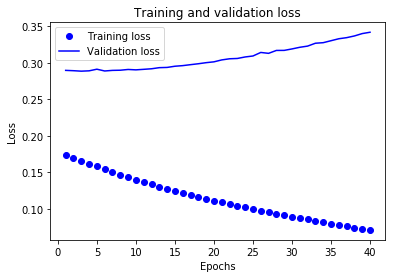

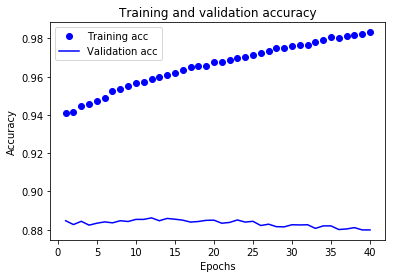

In [34]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

在该图中，点表示训练误差和精度，实线表示验证误差和精度。

注意看，训练误差随着每轮迭代而减少，并且训练准确度随着每轮迭代而增加。 
这说明在使用梯度下降优化时是预期的 - 它应该在每次迭代时最小化损失。

它们似乎在大约二十个迭代后达到峰值。 这是过度拟合的一个例子：模型在训练数据上的表现比在测试数据上表现得更好。
模型过度优化并学习特定于训练数据的特征，这些特征不会推广到测试数据。

对于这种特殊情况，我们可以通过在二十个左右的时期之后停止训练来防止过拟合。